# Reporting At Item Level, Multiple time cuts

In [1]:
#base imports
import sys
import os
from pathlib import Path
import pandas as pd
import warnings
import itertools
import numpy as np
import datetime as dt

#time series imports
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#typeing
from typing import Mapping, Set, Sequence, Tuple, TypeVar, List, Generic, Dict, Any

#tester
from TS_ttester import TS_ttester

# converters 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#Thin Database
from thin_db import ThinDB
os.environ['DATA_DIR'] = str(Path('./datadir'))
os.environ['DB_CREDS'] = "config.json"

In [2]:
# Set up tdb
tdb = ThinDB()
#import and run item info queries
cache_set = False

In [3]:
#register converters?
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Query For Cases

In [4]:
case_query = Path('./query/v3_items_withdr_cases_10-11.sql').read_text()
df_cases = tdb.fetch(case_query, cache = cache_set)

Attempting to fetch fresh data from DB...
Query finished, saving to cache


In [5]:
# pivot data
cases_pivot = df_cases.pivot(
                    index = 'delivery_date', 
                    columns = 'last_sku', 
                    values = 'cases_sold'
                    )

In [6]:
#get go live date
go_live_date = df_cases[['last_sku','golive_min']].drop_duplicates(
                        subset = ['last_sku','golive_min'], keep = 'first')
go_live_date.reset_index(inplace = True, drop = True)
#change to datetime
go_live_date['golive_min'] = go_live_date['golive_min'].apply( lambda x: dt.datetime.strptime(x, '%m/%d/%Y'))

In [7]:
#inspect dates
date_list = go_live_date[['golive_min']].drop_duplicates(keep = 'first').reset_index(drop = True)
print(date_list)

  golive_min
0 2020-09-14
1 2020-09-21
2 2020-08-29
3 2020-09-28
4 2020-09-04


# Prep and feed data into testers

In [8]:
#check how many in each date group
for d in date_list['golive_min']:
    print(d)
    print( len( go_live_date.loc[ go_live_date['golive_min'] == d] ) )

2020-09-14 00:00:00
265
2020-09-21 00:00:00
125
2020-08-29 00:00:00
93
2020-09-28 00:00:00
35
2020-09-04 00:00:00
13


In [9]:
#set up list to store dictionary results
result_list = list()

#loop through different date tranches
for d in date_list['golive_min']:
    
    #what day are we dealing with
    print(d)
    
    #choose number of obs
    look = (dt.date.today() - d.date()).days
    print(look)
    
    #redefine tester with that info
    tester = TS_ttester( 
                treatment_date = d,
                look_back = max(19,look),
                look_forward = look
                )
    
#     #redefine tester with that info
#     tester = TS_ttester( 
#                 treatment_date = d,
#                 look_back = 19,
#                 look_forward = 18
#                 )
    
    #get the sku list
    sku_list = go_live_date.loc[ go_live_date['golive_min'] == d]['last_sku']
    
    #loop through each sku
    for sku in sku_list:
        
        #clean the series
        demand_series = cases_pivot[ sku ].asfreq( pd.tseries.offsets.CustomBusinessDay( 
            weekmask = "Mon Tue Wed Thu Fri Sat")).fillna(0)
                
        #pass into tester
        results, left, right = tester.t_test(demand_series)
        
        #add sku, and experiment date to results
        results['sku'] = sku
        results['golive'] = d
        
        #add results to list
        result_list.append(results)
        

2020-09-14 00:00:00
31


/Users/lewis.warne/.local/share/virtualenvs/data_science-17gAGHGO/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:617: RuntimeWarning: invalid value encountered in double_scalars
  tstat = (value1 - value2 - diff) / std_diff
/Users/lewis.warne/ws/data_science/src/research/lewis/TS_ttester.py:67: RuntimeWarning: invalid value encountered in double_scalars
  scaled_change_in_mean = change_in_mean / pooled_std


2020-09-21 00:00:00
24
2020-08-29 00:00:00
47
2020-09-28 00:00:00
17
2020-09-04 00:00:00
41


# Export Data

In [10]:
df = pd.DataFrame.from_records(result_list)
df.head()

,tstat,pval,df,mean_diff,pooled_std,scaled_mean_diff,left_mean,right_mean,sku,golive
0,1.469199,0.147690,53.0,-0.074074,0.186924,-0.396279,0.074074,0.000000,100036,2020-09-14
1,-2.005726,0.050002,53.0,0.212963,0.393652,0.540994,0.037037,0.250000,100060,2020-09-14
2,0.389216,0.698676,53.0,-0.041005,0.390597,-0.104981,0.148148,0.107143,100089,2020-09-14
3,1.674308,0.099962,53.0,-0.190476,0.421779,-0.451602,0.333333,0.142857,100094,2020-09-14
4,-0.191525,0.848846,53.0,0.052910,1.024215,0.051659,0.518519,0.571429,100281,2020-09-14


In [11]:
df.to_csv('./csv_exports/item_level_cases_10-15.csv')

# show charts

In [ ]:
#loop through different date tranches
for d in date_list['golive_min']:
    fig, ax1 = plt.subplots(figsize=(15, 6))
    n, bins, patches = plt.hist( df.loc[ df['golive'] == d]['scaled_mean_diff']
                , bins = 40
            )
    plt.xlabel("Scaled Difference in Mean")
    plt.ylabel("Number of SKUs")
    plt.title("Change in Demand {} product set".format(d.date()))

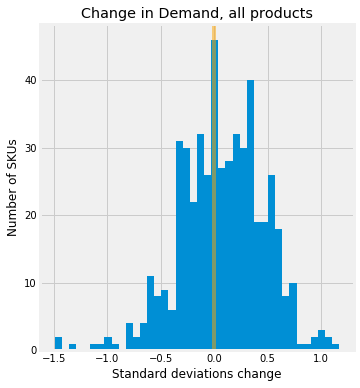

In [134]:
#all in one date tranch
fig, ax1 = plt.subplots(figsize=(5, 6))
n, bins, patches = plt.hist( df['scaled_mean_diff']
        , bins = 40
    )
plt.xlabel("Standard deviations change")
plt.ylabel("Number of SKUs")
plt.title("Change in Demand, all products".format(d.date()))
plt.axvline(0, alpha = .5, color = 'orange')

# item level demand chart (on demand)

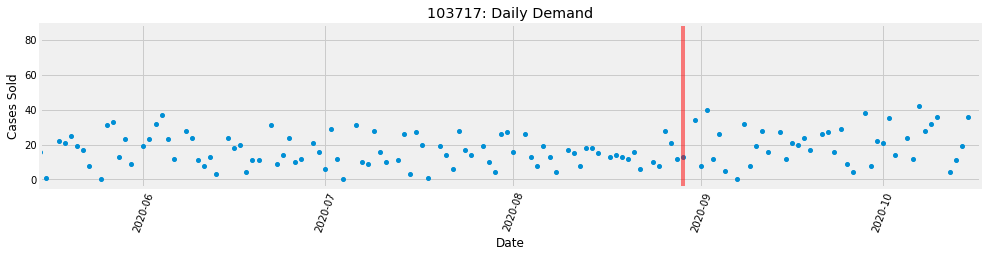

In [35]:
check = [103717]

#plot for all 
for int_sku in check:
    
    # clean the data and convert it to time series
    s_sku = str(int_sku)
    demand_series = cases_pivot[ s_sku ].asfreq( pd.tseries.offsets.CustomBusinessDay( 
        weekmask = "Mon Tue Wed Thu Fri Sat")).fillna(0)
    
    #plot data 
    fig, ax1 = plt.subplots(figsize=(15, 3))
    plt.xticks(rotation=70)
    ax1.set_title( '{}: Daily Demand'.format(s_sku) )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cases Sold')
    ax1.plot(demand_series,label = 'cases_sold', ls = '', marker = 'o', markersize=4)
    ax1.set_xlim(left = dt.datetime(2020, 5, 15), right = dt.date.today() + dt.timedelta(days=1) )
#     ax1.set_ylim(top = 40 )
    #add line a change date for visuals
    plt.axvline(go_live_date[go_live_date['last_sku'] == s_sku]['golive_min'], alpha = .5, color = 'red')
#     plt.axvline(go_live_date[go_live_date['last_sku'] == s_sku]['golive_min'], alpha = .5, color = 'blue')

    plt.show()

# Use extended data for applicable skus


In [73]:
target_list = [101380, 103599, 110773, 103477, 108728]

In [121]:
short_list = list()

#loop through each sku
for sku in target_list:
    
    sku = str(sku)
    
    a = go_live_date.loc[ go_live_date['last_sku'] == sku]['golive_min']
    a.reset_index(inplace = True, drop = True)
    a[0]
    
    d = a[0]
    
    print(d)
    
    #choose number of obs
    look = (dt.date.today() - pd.to_datetime(d).date()).days
    
    #redefine tester with that info
    tester = TS_ttester( 
                treatment_date = d,
                look_back = max(19,look),
                look_forward = look
                )

    #clean the series
    demand_series = cases_pivot[ sku ].asfreq( pd.tseries.offsets.CustomBusinessDay( 
        weekmask = "Mon Tue Wed Thu Fri Sat")).fillna(0)

    #pass into tester
    results, left, right = tester.t_test(demand_series)

    #add sku, and experiment date to results
    results['sku'] = sku
    results['golive'] = d

    #add results to list
    short_list.append(results)

2020-08-29 00:00:00
2020-08-29 00:00:00
2020-08-29 00:00:00
2020-09-28 00:00:00
2020-09-28 00:00:00


In [122]:
df_short = pd.DataFrame.from_records(short_list)
df_short.head()

,tstat,pval,df,mean_diff,pooled_std,scaled_mean_diff,left_mean,right_mean,sku,golive
0,-2.441167,0.016999,75.0,2.787112,5.008822,0.556441,12.410256,15.197368,101380,2020-08-29
1,-0.111404,0.911594,75.0,0.007169,0.282331,0.025393,0.147436,0.154605,103599,2020-08-29
2,-2.032924,0.045600,75.0,6.514170,14.057779,0.463385,17.538462,24.052632,110773,2020-08-29
3,-2.747282,0.010390,28.0,0.909502,0.898537,1.012203,0.205882,1.115385,103477,2020-09-28
4,-2.542053,0.016838,28.0,2.443439,2.608870,0.936589,4.274510,6.717949,108728,2020-09-28


In [80]:
go_live_date.head()

,last_sku,golive_min
0,100036,2020-09-14
1,100056,2020-09-21
2,100060,2020-09-14
3,100089,2020-09-14
4,100090,2020-09-21


In [119]:
a = go_live_date.loc[ go_live_date['last_sku'] == '101380']['golive_min']
a.reset_index(inplace = True, drop = True)
a[0]

Timestamp('2020-08-29 00:00:00')